# Bias Analysis: NovaCred Credit Applications

**Dataset:** `data/cleaned_credit_applications.csv` pre-cleaned by `01-data-quality.ipynb`  

## Scope

This notebook covers:

1. **Disparate Impact Ratio** for gender: DI = approval_rate(Female) / approval_rate(Male) flag if < 0.8
2. **Proxy discrimination**  correlations between non-protected attributes and outcomes
3. **Age-based bias** patterns
4. **Interaction effects** (e.g. age × gender)

In [18]:
#Role responsibilities: bias analysis, fairness metrics, statistical testing.

#TODO: Visualizations (done)
#TODO: Bias detection
#TODO: Investigate whether any non-protected attributes serve as proxies for protected characteristics
#TODO: Analyze correlations between fields and outcomes
#TODO: Statistical testing



In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Seaborn setup
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

colors = [
    "#0066FF",  # vibrant blue
    "#FF1493",  # hot pink
    "#00C853",  # bright green
    "#FFD600",  # vivid yellow
    "#8B4513",  # rich brown
    "#FF2D2D",  # bright red
    "#7C3AED",  # bold purple (extra)
    "#00E5FF",  # bright cyan (extra)
    "#FF8C00"   # vivid orange (extra)
]
sns.set_palette(colors)
sns.set_color_codes("pastel")


plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3

# Load pre-cleaned dataset from the data quality pipeline
df = pd.read_csv("../data/cleaned_credit_applications.csv")

# Print the number of records and columns in the loaded dataframe
print(f"Loaded {len(df)} records with {df.shape[1]} columns")

# Set column names for gender and loan approval status
gender_col   = 'applicant_info.gender_clean'
approved_col = 'decision.loan_approved'

df.head(8)

Loaded 500 records with 37 columns


,_id,processing_timestamp,applicant_info.full_name,applicant_info.email,applicant_info.ssn,applicant_info.ip_address,applicant_info.gender,applicant_info.date_of_birth,applicant_info.zip_code,financials.annual_income,...,spending_Fitness,spending_Entertainment,spending_Insurance,spending_Travel,spending_Transportation,spending_Utilities,spending_Groceries,spending_Education,spending_Adult Entertainment,spending_Gambling
0,app_200,2024-01-15T00:00:00Z,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036.0,73000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,app_037,NaN,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,M,1992-03-31,10032.0,78000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,app_215,NaN,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075.0,61000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,app_024,NaN,Thomas Lee,thomas.lee6@protonmail.com,194-35-1833,192.168.175.67,Male,1983-04-25,10077.0,103000.0,...,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,app_184,2024-01-15T00:00:00Z,Brian Rodriguez,brian.rodriguez86@aol.com,480-41-2475,172.29.125.105,M,1999-05-21,10080.0,57000.0,...,NaN,463.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,app_275,NaN,Maria Miller,maria.miller67@outlook.com,417-25-4912,172.25.58.70,F,14/02/1982,10019.0,110000.0,...,NaN,571.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,app_099,NaN,Nicholas King,nicholas.king46@outlook.com,613-23-2503,10.62.62.45,Male,28/01/1990,10022.0,55000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,app_246,NaN,Susan Rivera,susan.rivera74@gmail.com,176-97-1864,192.168.158.59,F,1991-10-11,90223.0,82000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
mask = df['applicant_info.date_of_birth_parsed'].isna()
still_unparsed = df.loc[mask, 'applicant_info.date_of_birth']

#initialize empty datetime series
parsed_dob = pd.Series(pd.NaT, index=still_unparsed.index)

formats = [
    '%d/%m/%Y',
    '%m/%d/%Y',
    '%Y/%m/%d',
    '%d-%m-%Y',
    '%d.%m.%Y',
    '%Y-%m-%d',
    '%B %d, %Y',
    '%b %d, %Y',
]

for fmt in formats:
    remaining_mask = parsed_dob.isna()
    parsed_dob.loc[remaining_mask] = pd.to_datetime(
        still_unparsed[remaining_mask],
        format=fmt,
        errors='coerce'
    )

#fill back into dataframe
df.loc[mask, 'applicant_info.date_of_birth_parsed'] = parsed_dob

#check remaining failures
remaining = df['applicant_info.date_of_birth_parsed'].isna().sum()
print(f"Unparsed dates remaining: {remaining}")

print(
    df[df['applicant_info.date_of_birth_parsed'].isna()]
    ['applicant_info.date_of_birth']
)

Unparsed dates remaining: 4
26     NaN
275    NaN
447    NaN
460    NaN
Name: applicant_info.date_of_birth, dtype: object


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   _id                                  500 non-null    object 
 1   processing_timestamp                 62 non-null     object 
 2   applicant_info.full_name             500 non-null    object 
 3   applicant_info.email                 489 non-null    object 
 4   applicant_info.ssn                   496 non-null    object 
 5   applicant_info.ip_address            496 non-null    object 
 6   applicant_info.gender                498 non-null    object 
 7   applicant_info.date_of_birth         496 non-null    object 
 8   applicant_info.zip_code              499 non-null    float64
 9   financials.annual_income             499 non-null    float64
 10  financials.credit_history_months     498 non-null    float64
 11  financials.debt_to_income       

In [23]:
df.rename(columns={col:col.replace('.','_') for col in df.columns}, inplace=True)

#drop rows missing gender or date of birth (needed for protected attributes)
df = df.dropna(subset=["applicant_info_gender_clean", "applicant_info_date_of_birth_parsed"])

#convert DOB to datetime
df["date_of_birth_parsed"] = pd.to_datetime(df["applicant_info_date_of_birth_parsed"], errors="coerce")

#drop rows where DOB conversion failed
df = df.dropna(subset=["date_of_birth_parsed"])

#adding age feature
df["age"] = (pd.Timestamp("today") - df["date_of_birth_parsed"]).dt.days // 365

#age groups
df["age_group"] = pd.cut(df["age"], bins=[18,30,45,60,100], labels=["18-29","30-44","45-59","60+"])

df["approved"] = df["decision_loan_approved"].astype(int)

cols_to_keep = [
    "_id",
    "applicant_info_ssn",
    "applicant_info_gender_clean",
    "date_of_birth_parsed",
    "age",
    "age_group",
    "decision_loan_approved",
    "applicant_info_zip_code",
    "financials_annual_income",
    "financials_savings_balance",

    #spending features (proxy analysis)
    "spending_Shopping",
    "spending_Rent",
    "spending_Alcohol",
    "spending_Dining",
    "spending_Healthcare",
    "spending_Fitness",
    "spending_Entertainment",
    "spending_Insurance",
    "spending_Travel",
    "spending_Transportation",
    "spending_Utilities",
    "spending_Groceries",
    "spending_Education",
    "spending_Adult Entertainment",
    "spending_Gambling",
]

df_analysis = df[cols_to_keep].copy()

df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495 entries, 0 to 499
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   _id                           495 non-null    object        
 1   applicant_info_ssn            495 non-null    object        
 2   applicant_info_gender_clean   495 non-null    object        
 3   date_of_birth_parsed          495 non-null    datetime64[ns]
 4   age                           495 non-null    int64         
 5   age_group                     495 non-null    category      
 6   decision_loan_approved        495 non-null    bool          
 7   applicant_info_zip_code       495 non-null    float64       
 8   financials_annual_income      494 non-null    float64       
 9   financials_savings_balance    494 non-null    float64       
 10  spending_Shopping             53 non-null     float64       
 11  spending_Rent                 59 non-

/var/folders/_v/59wc1djd1x590_smjz58xrkh0000gn/T/ipykernel_56808/2957012193.py:1: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(x="decision_loan_approved", data=df_analysis, hue='decision_loan_approved', palette=colors[6:])


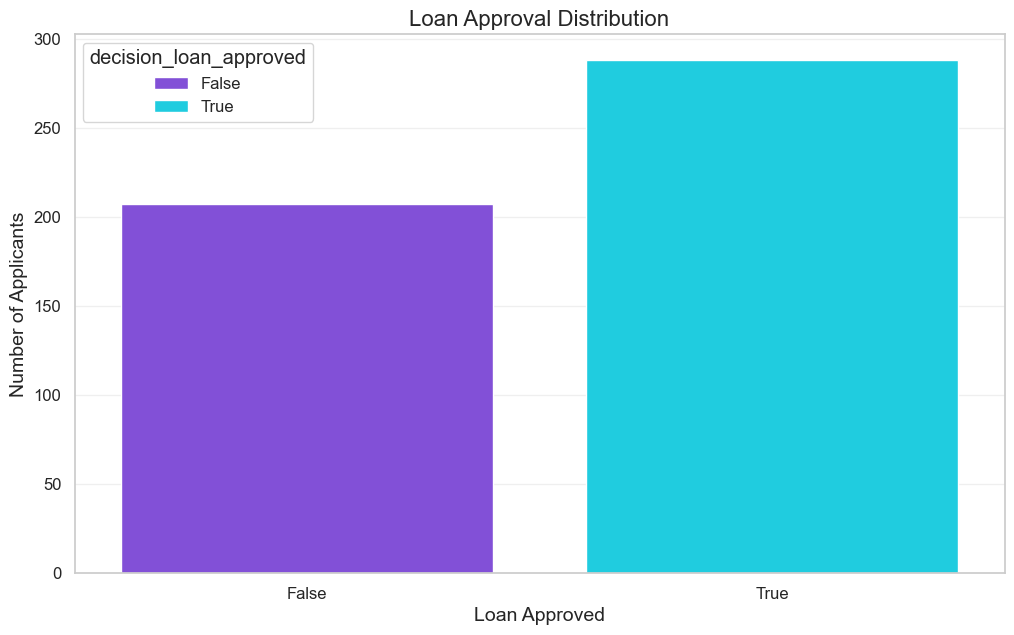

In [46]:
sns.countplot(x="decision_loan_approved", data=df_analysis, hue='decision_loan_approved', palette=colors[6:])
plt.title("Loan Approval Distribution")
plt.ylabel("Number of Applicants")
plt.xlabel("Loan Approved")
plt.show()

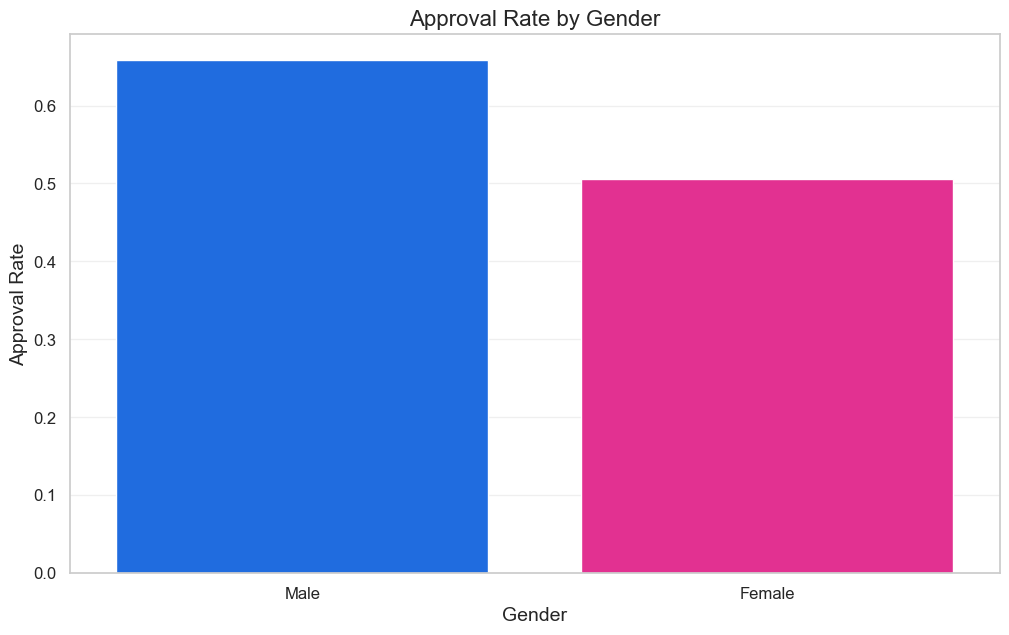

In [25]:
sns.barplot(
    x="applicant_info_gender_clean",
    y="decision_loan_approved",
    data=df_analysis,
    estimator=lambda x: sum(x)/len(x),
    errorbar=None,
    hue="applicant_info_gender_clean",
)
plt.title("Approval Rate by Gender")
plt.ylabel("Approval Rate")
plt.xlabel("Gender")
plt.show()

<Axes: xlabel='age', ylabel='Count'>

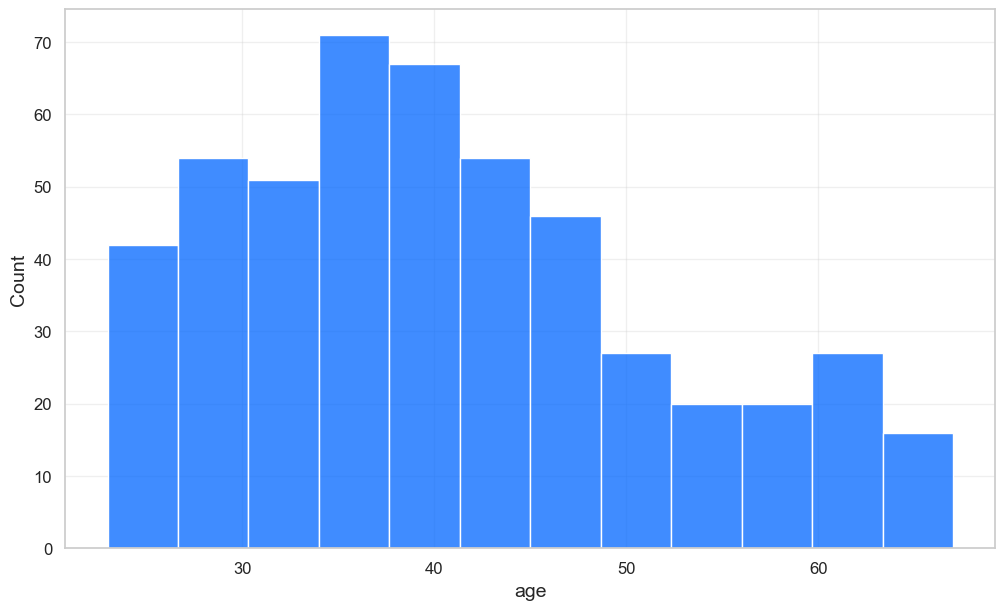

In [26]:
sns.histplot(data=df_analysis['age'])

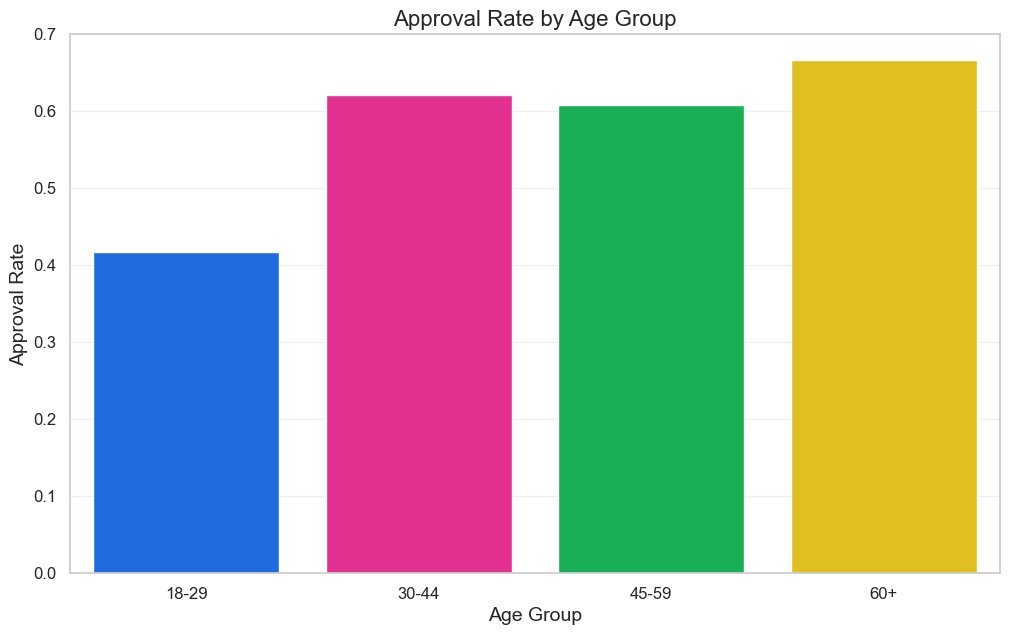

In [27]:
sns.barplot(
    x="age_group",
    y="decision_loan_approved",
    data=df_analysis,
    estimator=lambda x: sum(x)/len(x),
    hue="age_group",
    errorbar=None
)
plt.title("Approval Rate by Age Group")
plt.ylabel("Approval Rate")
plt.xlabel("Age Group")
plt.show()

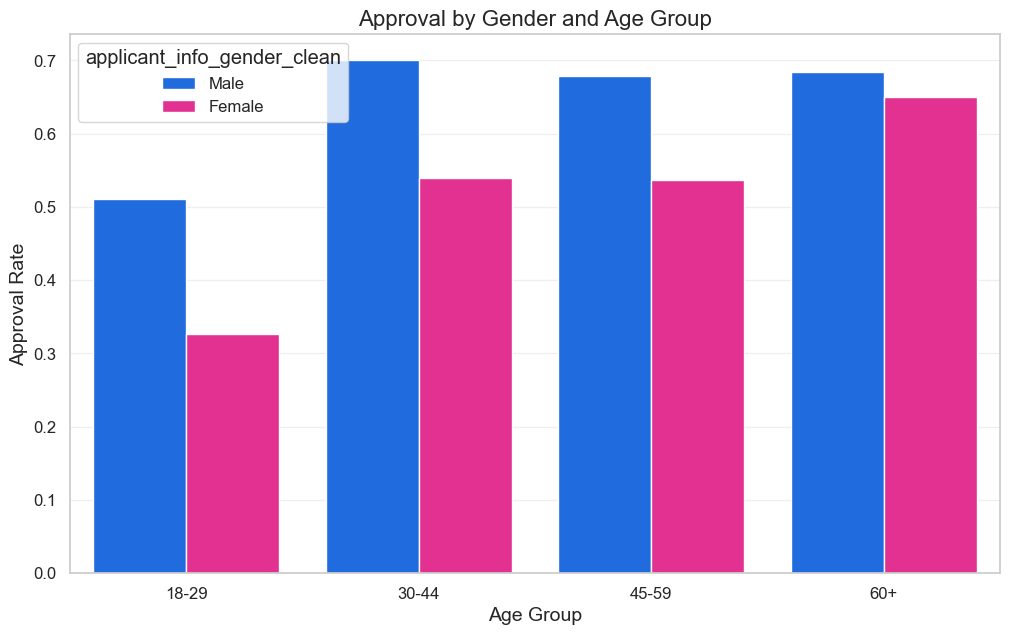

In [28]:
sns.barplot(
    x="age_group",
    y="decision_loan_approved",
    hue="applicant_info_gender_clean",
    data=df_analysis,
    estimator=lambda x: sum(x)/len(x),
    errorbar=None
)
plt.title("Approval by Gender and Age Group")
plt.ylabel("Approval Rate")
plt.xlabel("Age Group")
plt.show()

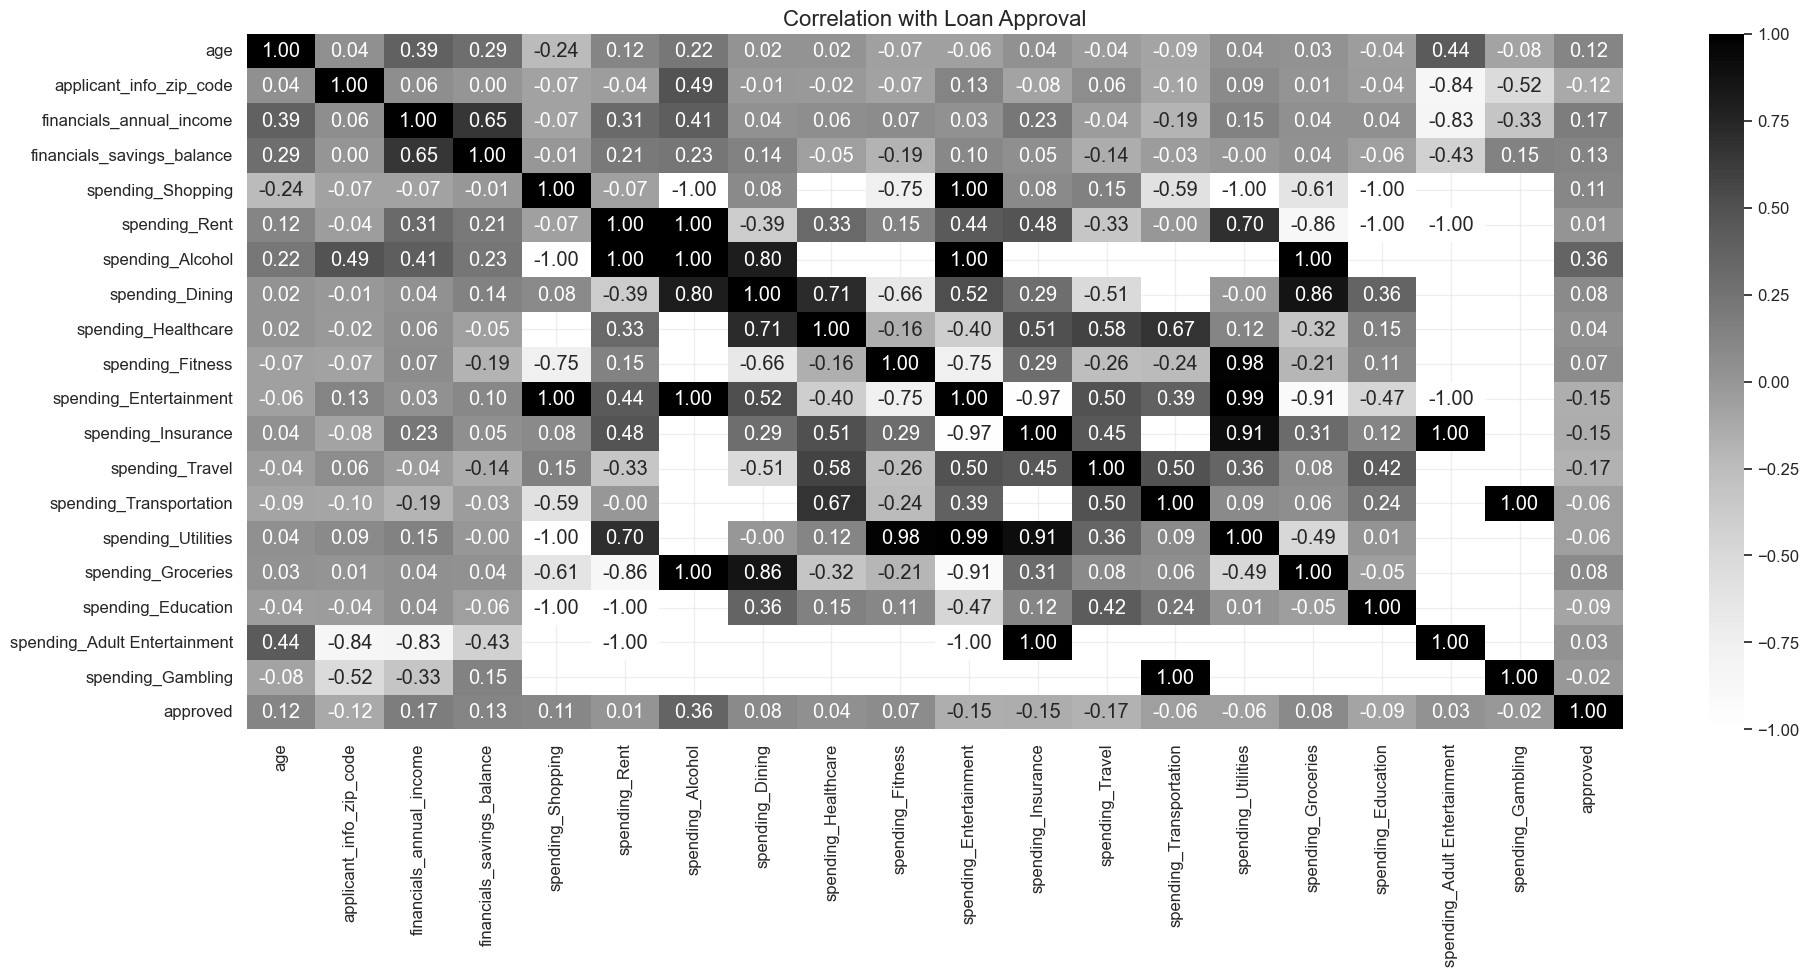

In [29]:
#convert approval from T/F to 0,1
df_corr = df_analysis.copy()
df_corr["approved"] = df_corr["decision_loan_approved"].astype(int)

numeric_df = df_corr.select_dtypes(include=["number"])

plt.figure(figsize=(20, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='Greys')
plt.title("Correlation with Loan Approval")
plt.tight_layout()
plt.show()

In [30]:
#gender bias
priv, unpriv = "Male", "Female"

p_priv = df_analysis[df_analysis["applicant_info_gender_clean"]==priv]["decision_loan_approved"].mean()
p_unpriv = df_analysis[df_analysis["applicant_info_gender_clean"]==unpriv]["decision_loan_approved"].mean()

di_gender = p_unpriv / p_priv
spd_gender = p_unpriv - p_priv

print(f"Approval rates: Male={p_priv:.2f}, Female={p_unpriv:.2f}")
print(f"Disparate Impact (DI): {di_gender:.2f}")
print(f"Statistical Parity Difference (SPD): {spd_gender:.2f}")

Approval rates: Male=0.66, Female=0.51
Disparate Impact (DI): 0.77
Statistical Parity Difference (SPD): -0.15


In [31]:
#age based discrimination
age_approval = df_analysis.groupby("age_group")["decision_loan_approved"].mean()
print(age_approval)

# Chi-square test
from scipy.stats import chi2_contingency

cont_age = pd.crosstab(df_analysis["age_group"], df_analysis["decision_loan_approved"])
chi2, p_age, _, _ = chi2_contingency(cont_age)
print("Age p-value:", p_age)

age_group
18-29    0.416667
30-44    0.620553
45-59    0.607477
60+      0.666667
Name: decision_loan_approved, dtype: float64
Age p-value: 0.003242384554219695


/var/folders/_v/59wc1djd1x590_smjz58xrkh0000gn/T/ipykernel_56808/2324015204.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_approval = df_analysis.groupby("age_group")["decision_loan_approved"].mean()


In [32]:
protected_attr = ['decision_loan_approved', 'applicant_info_gender_clean', 'age_group', ]

In [33]:
df_explore_zip_code_bias = df_analysis.groupby('applicant_info_zip_code')['decision_loan_approved'].agg(['mean', 'count']).reset_index().sort_values(by='count', ascending=False)
df_explore_zip_code_bias

,applicant_info_zip_code,mean,count
43,10048.0,0.750000,8
89,10096.0,0.285714,7
181,90284.0,0.428571,7
16,10019.0,0.333333,6
3,10004.0,1.000000,6
17,10020.0,0.666667,6
52,10057.0,0.500000,6
111,90205.0,0.200000,5
36,10041.0,0.600000,5
153,90252.0,0.800000,5


<Axes: xlabel='mean', ylabel='Count'>

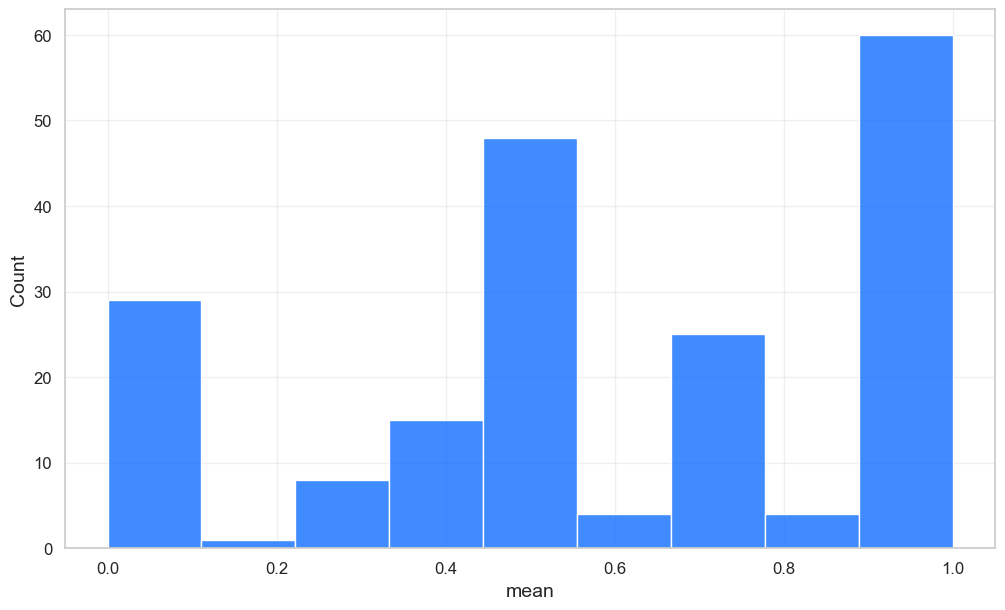

In [34]:
sns.histplot(data=df_explore_zip_code_bias, x="mean")